In [1]:
type Household
    r::Float64
    w::Float64
    beta::Float64
    a_min::Float64
    Pi::Array{Float64,2}
    z_vals::Array{Float64,1}
    a_max::Float64
    a_size::Int64
    z_size::Int64
    a_vals::LinSpace{Float64}
    n::Int64
    Q::Array{Float64,3}
    R::Array{Float64,2}
    
    function Household(r::Float64, w::Float64, beta::Float64, a_min::Float64, Pi::Array{Float64,2}, z_vals::Array{Float64,1}, a_max::Float64, a_size::Int64)
        z_size = length(z_vals)
        a_vals = linspace(a_min, a_max, a_size)
        n = a_size * z_size
        
        Q = zeros(n,a_size,n)
        populate_Q(Q,a_size,z_size,Pi)
        
        R = ones(n,a_size).*-Inf
        populate_R(R,a_size,z_size,a_vals,z_vals,r,w)
        
        new(r,w,beta,a_min,Pi,z_vals,a_max,a_size,z_size,a_vals,n,Q,R)
    end
end

function Household()
    Household(0.01,1.0,0.96,1e-10,[0.9 0.1; 0.1 0.9],[0.1, 1.0],18.0,200)
end

function set_prices!(am, r, w)
    am.r = r
    am.w = w
    populate_R(am.R, am.a_size, am.z_size, am.a_vals, am.z_vals, am.r, am.w)
end

function populate_Q(Q, a_size, z_size, Pi)
    n = a_size * z_size
    
    for s_i in 1:n
        
        z_i = (s_i-1) % z_size + 1
        
        for a_i in 1:a_size
            for next_z_i in 1:z_size
                Q[s_i, a_i, (a_i-1) * z_size + (next_z_i)] = Pi[z_i, next_z_i]
            end
        end
    end
end

function populate_R(R, a_size, z_size, a_vals, z_vals, r, w)
    n = a_size * z_size
    for s_i in 1:n #loop over all states:
        #with z_size=2 the indexing is: s_i=1 is (a[1],z[1]), s_i=2 is (a[1],z[2]), s_i=3 is (a[2],z[1])
        
        a_i = floor(Int64,(s_i-1) / z_size) + 1
        z_i = z_i = s_i % z_size + 1
        a = a_vals[a_i]
        z = z_vals[z_i]

        for next_a_i in 1:a_size
            a_next = a_vals[next_a_i]
            c = w * z + (1 + r) * a - a_next
            R[s_i, next_a_i] = c > 0 ? log(c) : -Inf
        end
    end
end

function asset_marginal(s_probs, a_size, z_size)
    a_probs = zeros(a_size)
    for a_i in 0:a_size-1
        for z_i in 0:z_size-1
            a_probs[a_i+1] += s_probs[a_i * z_size + z_i+1]
        end
    end
    return a_probs
end 

asset_marginal (generic function with 1 method)

In [2]:
@time am = Household(0.03,0.956,0.96,1e-10,[0.9 0.1; 0.1 0.9],[0.1, 1.0],18.0,200);

  0.549210 seconds (186.15 k allocations: 253.227 MB, 2.05% gc time)


In [3]:
using PyPlot
using QuantEcon
using Roots

In [4]:
@time am_ddp = DiscreteDP(am.R, am.Q, am.beta)
@time results = solve(am_ddp, PFI);

  0.417427 seconds (182.52 k allocations: 8.487 MB)
  6.060623 seconds (2.37 M allocations: 290.504 MB, 2.17% gc time)


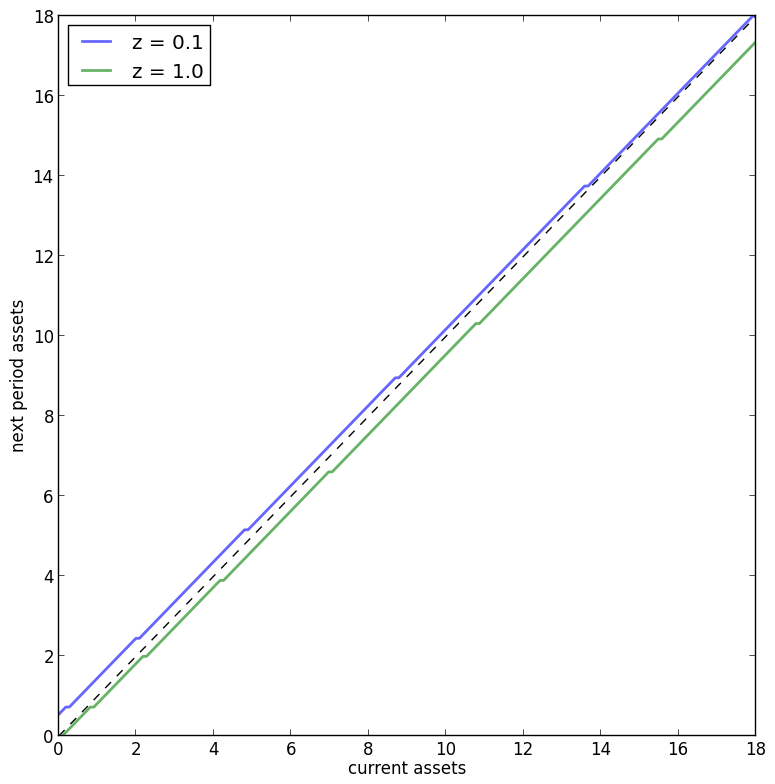

PyObject <matplotlib.legend.Legend object at 0x327872a90>

In [5]:
z_size, a_size = am.z_size, am.a_size
z_vals, a_vals = am.z_vals, am.a_vals
n = a_size * z_size

# Get all optimal actions across the set of a indices with z fixed in each row
a_star = zeros(z_size, a_size)

for s_i in 1:n #loop over all states:
    #with Z_size=2 the indexing is: s_i=1 is (a[1],z[1]), s_i=2 is (a[1],z[2]), s_i=3 is (a[2],z[1])
    
    a_i = floor(Int64,(s_i-1) / z_size) + 1
    z_i = (s_i-1) % z_size + 1
    a_star[z_i, a_i] = a_vals[results.sigma[s_i]]
end

fig, ax = subplots(figsize=(9, 9))
ax[:plot](a_vals, a_vals, "k--")

for i in 1:z_size
    z = z_vals[i]
    lb = "z = $z"
    ax[:plot](collect(a_vals), squeeze(a_star[i, :],1), lw=2, alpha=0.6, label=lb)
end

ax[:set_xlabel]("current assets")
ax[:set_ylabel]("next period assets")
ax[:legend](loc="upper left")

Calculating Equilibrium
--

In [34]:
A = 2.5
N = 0.05
alpha = 0.33
beta = 0.96

r_to_w(r, A, alpha) = A * (1 - alpha) * (alpha ./ (1 +r)).^(alpha / (1 - alpha))

rd(K, A, alpha) = A * alpha * (N ./ K).^(1 - alpha)
Kd(r, A, alpha) = (A * alpha ./ r) .^(1/(1-alpha)) * N
        
function prices_to_capital_stock(am, r, A, alpha)
    w = r_to_w(r, A, alpha)
    set_prices!(am, r, w)
    aiyagari_ddp = DiscreteDP(am.R, am.Q, beta)
    # Compute the optimal policy
    results = solve(aiyagari_ddp, PFI)
    # Compute the stationary distribution
    stationary_probs = stationary_distributions(results.mc)[1]
    # Extract the marginal distribution for assets
    asset_probs = asset_marginal(stationary_probs, am.a_size, am.z_size)
    # Return K
    return sum(asset_probs .* collect(am.a_vals))
end

prices_to_capital_stock (generic function with 1 method)

In [35]:
# Create an instance of Household 
am = Household(0.01,1.0,0.96,1e-10,[0.9 0.1; 0.1 0.9],[0.1, 1.0],20.0,200)

# Use the instance to build a discrete dynamic program
am_ddp = DiscreteDP(am.R, am.Q, am.beta)

# Create a grid of r values at which to compute demand and supply of capital
num_points = 20
r_vals = linspace(0.005, 0.04, num_points)

# Compute supply of capital
k_vals = Array(Float64,num_points)

for (i, r) in enumerate(r_vals)
    k_vals[i] = prices_to_capital_stock(am, r, A, alpha)
end

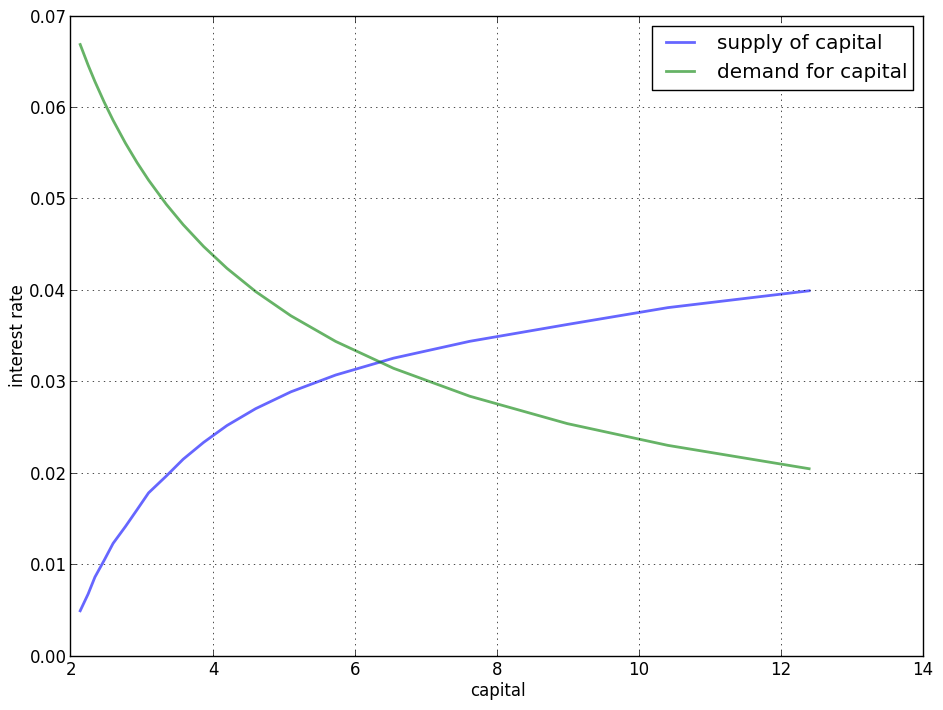

PyObject <matplotlib.legend.Legend object at 0x30cce7450>

In [8]:
fig, ax = subplots(figsize=(11, 8))
ax[:plot](k_vals, r_vals, lw=2, alpha=0.6, label="supply of capital")
ax[:plot](k_vals, rd(k_vals, A, alpha), lw=2, alpha=0.6, label="demand for capital")
ax[:grid]()
ax[:set_xlabel]("capital")
ax[:set_ylabel]("interest rate")
ax[:legend](loc="upper right")

In [79]:
excess_demand_K(r) = Kd(r, A, alpha) - prices_to_capital_stock(am, r, A, alpha);

In [76]:
@time fzero(excess_demand_K,0.03,0.04)

 86.060861 seconds (2.09 M allocations: 9.407 GB, 2.72% gc time)


0.0321879158809385